# Import Libraries

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Load Data

In [2]:
## Read Files

gdf_lsoa = gpd.read_file("Data/manchester_lsoa/manchester_lsoa.shp")

## Supply Data

df_bus = pd.read_csv("Data/TfGMStoppingPoints.csv")

df_stations = pd.read_csv("Data/TfGMMetroRailStops.csv")

lsoa_centroid = gpd.read_file("Data/lsoa_centroids/lsoa_centroid.shp")

## Demand Data

df_pop = pd.read_csv("Data/population_lsoa.csv", skiprows=3, low_memory=False)

df_car_disabled = pd.read_csv("Data/car_disabled_lsoa.csv")

df_deprived = pd.read_csv("Data/employment_deprived_household.csv")

df_household = pd.read_csv("Data/number_of_households.csv")

# Supply Variables Preparation

### Bus Density

In [3]:
## Create gdf of bus stop points from df based on easting and northing
bus_points = gpd.GeoDataFrame(df_bus, geometry=gpd.points_from_xy(df_bus.Easting, df_bus.Northing))
bus_points.set_crs(epsg=27700, inplace=True)

,AtcoCode,NaptanCode,PlateCode,CleardownCode,CommonName,CommonNameLang,ShortCommonName,ShortCommonNameLang,Landmark,LandmarkLang,...,DefaultWaitTime,Notes,NotesLang,AdministrativeAreaCode,CreationDateTime,ModificationDateTime,RevisionNumber,Modification,Status,geometry
0,1800WKH4032,NaN,NaN,NaN,Churchlands Lane,NaN,NaN,NaN,CHURCHLANDS LA,NaN,...,NaN,NaN,NaN,83,2007-11-01T00:00:00,2007-11-01T00:00:00,0,new,del,POINT (356697.000 410685.000)
1,1800SBT0641,NaN,NaN,NaN,High Street,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,83,2004-09-14T00:00:00,2019-07-31T14:34:30,1,rev,act,POINT (384219.000 398501.000)
2,1800SBT0351,NaN,NaN,NaN,Peter Street,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,83,2004-09-14T00:00:00,2019-07-31T14:47:41,1,rev,act,POINT (383740.000 397932.000)
3,1800SG44991,MANJMGMW,NaN,NaN,A34 Bridge,NaN,A34 Bridge,NaN,HOUSE 61,NaN,...,NaN,INDICATOR AMENDED,NaN,83,2014-02-17T00:00:00,2014-02-17T00:00:00,1,rev,act,POINT (385992.000 386275.000)
4,1800SGH2781,NaN,NaN,NaN,A34 Roundabout (to def rte),NaN,NaN,NaN,HANDFORTH BYPAS,NaN,...,NaN,NaN,NaN,83,2007-11-01T00:00:00,2007-11-01T00:00:00,0,new,del,POINT (386832.000 384681.000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21101,1800SBH1601,NaN,NaN,NaN,York Street (to define route),NaN,NaN,NaN,York Street (to define route),NaN,...,NaN,NaN,NaN,83,2007-11-01T00:00:00,2007-11-01T00:00:00,0,new,del,POINT (384318.000 398099.000)
21102,1800NE16201,MANDWTDG,NaN,NaN,Yorkshire St,NaN,Yorkshire St,NaN,BANK,NaN,...,NaN,STOP LOCATION AMENDED,NaN,83,2015-04-28T00:00:00,2015-04-28T00:00:00,1,rev,act,POINT (389821.000 413670.000)
21103,1800NB40971,MANDJWGM,NaN,NaN,Youth Club,NaN,Youth Club,NaN,GARAGES,NaN,...,NaN,INDICATOR AMENDED,NaN,83,2010-04-20T00:00:00,2010-04-20T00:00:00,1,rev,act,POINT (385196.000 404103.000)
21104,1800NB40961,MANDJWGJ,NaN,NaN,Youth Club,NaN,Youth Club,NaN,HOUSE 208,NaN,...,NaN,NaN,NaN,83,2007-11-01T00:00:00,2007-11-01T00:00:00,0,new,act,POINT (385215.000 404125.000)


In [4]:
## Spatial join bus stops to lsoa to count the total number of bus stops per lsoa
lsoa_bus = gpd.sjoin(gdf_lsoa, bus_points, how="left", predicate="contains")
bus_counts_lsoa = lsoa_bus.groupby("lsoa21cd").size().reset_index(name="bus_stops_count")

## Calculate area of each lsoa in sqkm
gdf_lsoa["area_sqkm"] = gdf_lsoa["geometry"].area / 10**6

In [5]:
gdf_lsoa

,label,lsoa21cd,lsoa21nm,name,geometry,area_sqkm
0,E92000001E12000002E08000001E02001011E01004901,E01004901,Bolton 028E,Bolton 028E,"POLYGON ((366003.093 406666.688, 366004.412 40...",0.354363
1,E92000001E12000002E08000002E02001030E01005001,E01005001,Bury 012B,Bury 012B,"POLYGON ((375480.348 408593.123, 375481.063 40...",0.238302
2,E92000001E12000002E08000001E02000995E01004840,E01004840,Bolton 012A,Bolton 012A,"POLYGON ((367374.781 411954.594, 367387.095 41...",4.181101
3,E92000001E12000002E08000002E02001030E01005006,E01005006,Bury 012D,Bury 012D,"POLYGON ((377212.688 410849.500, 377231.906 41...",1.772635
4,E92000001E12000002E08000001E02000986E01004773,E01004773,Bolton 003D,Bolton 003D,"POLYGON ((371776.559 412463.204, 371825.243 41...",0.266227
...,...,...,...,...,...,...
1764,E92000001E12000002E08000010E02001306E01006410,E01006410,Wigan 020E,Wigan 020E,"POLYGON ((357596.954 403017.375, 357616.740 40...",0.628715
1765,E92000001E12000002E08000010E02001307E01006400,E01006400,Wigan 021D,Wigan 021D,"POLYGON ((356213.760 403792.397, 356213.312 40...",0.569408
1766,E92000001E12000002E08000010E02001317E01006331,E01006331,Wigan 031D,Wigan 031D,"POLYGON ((367336.970 401009.452, 367340.657 40...",0.596520
1767,E92000001E12000002E08000010E02001297E01006397,E01006397,Wigan 011C,Wigan 011C,"POLYGON ((354859.312 406046.904, 354861.775 40...",0.147755


In [6]:
## Create a gdf to store the supply variables
lsoa_supply = pd.merge(gdf_lsoa[["lsoa21cd", "lsoa21nm", "geometry", "area_sqkm"]], bus_counts_lsoa, on="lsoa21cd")

## Calculate bus stop density in each lsoa
lsoa_supply["bus_stops_density"] = lsoa_supply["bus_stops_count"] / lsoa_supply["area_sqkm"]

In [7]:
lsoa_supply

,lsoa21cd,lsoa21nm,geometry,area_sqkm,bus_stops_count,bus_stops_density
0,E01004901,Bolton 028E,"POLYGON ((366003.093 406666.688, 366004.412 40...",0.354363,4,11.287876
1,E01005001,Bury 012B,"POLYGON ((375480.348 408593.123, 375481.063 40...",0.238302,4,16.785438
2,E01004840,Bolton 012A,"POLYGON ((367374.781 411954.594, 367387.095 41...",4.181101,25,5.979287
3,E01005006,Bury 012D,"POLYGON ((377212.688 410849.500, 377231.906 41...",1.772635,26,14.667433
4,E01004773,Bolton 003D,"POLYGON ((371776.559 412463.204, 371825.243 41...",0.266227,9,33.805782
...,...,...,...,...,...,...
1764,E01006410,Wigan 020E,"POLYGON ((357596.954 403017.375, 357616.740 40...",0.628715,8,12.724362
1765,E01006400,Wigan 021D,"POLYGON ((356213.760 403792.397, 356213.312 40...",0.569408,1,1.756210
1766,E01006331,Wigan 031D,"POLYGON ((367336.970 401009.452, 367340.657 40...",0.596520,6,10.058336
1767,E01006397,Wigan 011C,"POLYGON ((354859.312 406046.904, 354861.775 40...",0.147755,4,27.071827


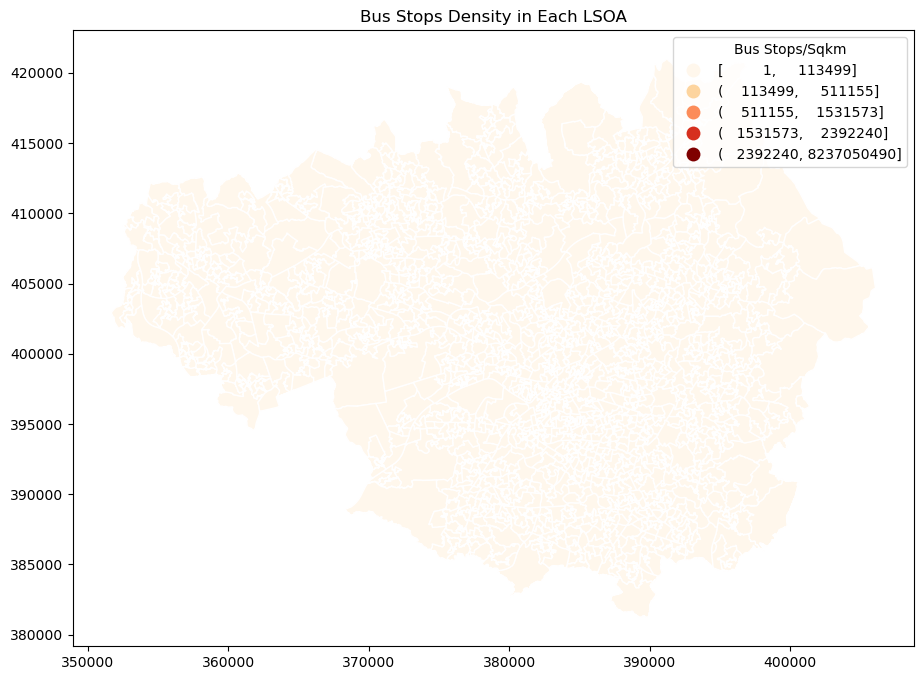

In [8]:
## Plot bus stop density
fig, ax = plt.subplots(1,1, figsize=(12,8))

lsoa_supply.plot(column="bus_stops_density",
                cmap="OrRd",
                ax=ax,
                edgecolor="1",
                legend=True,
                legend_kwds=dict(fmt="{:.0f}", interval=True),
                scheme="natural_breaks")

ax.set_title("Bus Stops Density in Each LSOA")
#ax.axis("off")
ax.get_legend().set_title("Bus Stops/Sqkm")
#ax.get_legend().set_bbox_to_anchor((0, 1))

In [9]:
lsoa_supply.nlargest(5, 'bus_stops_density')

,lsoa21cd,lsoa21nm,geometry,area_sqkm,bus_stops_count,bus_stops_density
351,E01025392,Rossendale 010D,"POLYGON ((384466.099 418971.799, 384466.087 41...",1.214027e-10,1,8.237050e+09
53,E01024915,Chorley 014A,"MULTIPOLYGON (((360575.800 412708.400, 360601....",4.180183e-07,1,2.392240e+06
428,E01025378,Rossendale 007B,"MULTIPOLYGON (((375568.600 419018.000, 375583....",4.383444e-07,1,2.281311e+06
613,E01018594,Cheshire East 004D,"MULTIPOLYGON (((386233.300 384253.300, 386230....",6.529235e-07,1,1.531573e+06
1655,E01025535,West Lancashire 015B,"MULTIPOLYGON (((351665.100 402908.300, 351672....",9.081682e-07,1,1.101118e+06


In [10]:
lsoa_supply[lsoa_supply["bus_stops_density"] < 1.5].reset_index()

,index,lsoa21cd,lsoa21nm,geometry,area_sqkm,bus_stops_count,bus_stops_density
0,18,E01005021,Bury 001F,"POLYGON ((375537.100 416388.300, 375541.862 41...",6.738709,5,0.741982
1,206,E01004999,Bury 014C,"POLYGON ((379041.500 409749.333, 379043.313 40...",1.959075,1,0.510445
2,348,E01005035,Bury 025C,"POLYGON ((380206.604 404183.345, 380332.835 40...",2.084037,2,0.959676
3,1076,E01006073,Tameside 009D,"POLYGON ((402464.800 401386.700, 402403.753 40...",13.657271,8,0.585769
4,1184,E01005561,Rochdale 014D,"POLYGON ((398054.800 414744.400, 398050.400 41...",11.908284,17,1.427578
5,1197,E01005409,Oldham 020D,"POLYGON ((405043.800 406254.300, 405063.017 40...",25.683160,23,0.895528
6,1242,E01005476,Rochdale 017A,"POLYGON ((388039.314 411160.842, 388053.814 41...",1.256730,1,0.795716
7,1328,E01005617,Salford 030B,"POLYGON ((371062.254 393052.301, 371067.194 39...",1.428616,1,0.699978
8,1336,E01005643,Salford 029E,"POLYGON ((373250.000 397022.176, 373237.000 39...",4.750085,3,0.631568
9,1349,E01006251,Wigan 029B,"POLYGON ((367581.000 396042.597, 367581.127 39...",13.684953,12,0.876875


### Station Proximity

In [11]:
## Create gdf of station points from df based on easting and northing
station_points = gpd.GeoDataFrame(df_stations, geometry=gpd.points_from_xy(df_stations.GMGRFE, df_stations.GMGRFN))
station_points.set_crs(epsg=27700, inplace=True)

,NPTREF,SMSREF,GPSLAT,GPSLON,GMGRFE,GMGRFN,RSTNAM,MAINRD,SIDEST,NETTYP,GAZREF,NETWRF,geometry
0,9100ALTRNHM,NaN,53.387668,-2.347158,377008,387924,ALTRINCHAM INTERCHANGE,STAMFORD NEW RD,MOSS LANE,R,E0028261,SJR032,POINT (377008.000 387924.000)
1,9100ARDWICK,NaN,53.471206,-2.213369,385934,397183,ARDWICK,DEVONSHIRE ST N,BLIND LANE,R,E0028484,EBR116,POINT (385934.000 397183.000)
2,9100ASHBRYS,NaN,53.471867,-2.194752,387150,397253,ASHBURYS,POTTERY LANE,JARMAIN STREET,R,N0074883,EBR115,POINT (387150.000 397253.000)
3,9100ASHONUL,NaN,53.491279,-2.094327,393839,399399,ASHTON UNDER LYNE,SACKVILLE ST,TURNER LANE,R,E0028492,EHR101,POINT (393839.000 399399.000)
4,9100ATHERTN,NaN,53.529109,-2.477990,368412,403710,ATHERTON,UPTON ROAD,BOLTON ROAD,R,E0028727,WKR069,POINT (368412.000 403710.000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,9400ZZMAWPK,MANTWGTM,53.407671,-2.295666,380442,390134,Wythenshawe Park,WYTHENSHAWE RD,NaN,M,N0075104,SBR694,POINT (380442.000 390134.000)
186,9400ZZMAWST,MANTMWGP,53.482488,-2.308000,379658,398461,Weaste,ECCLES NEW RD,KNOTT STREET,M,E0029513,NFR486,POINT (379658.000 398461.000)
187,9400ZZMAWTD,MANTWDGA,53.424477,-2.236039,384412,391989,West Didsbury,LAPWING LANE,NaN,M,E0029519,SBR648,POINT (384412.000 391989.000)
188,9400ZZMAWWD,MANTWGDJ,53.542321,-2.125871,391756,405081,Westwood,MIDDLETON RD,NaN,M,E0029527,EDR676,POINT (391756.000 405081.000)


In [12]:
## Function to calculate the distance to the nearest Transport Infrastructure
def nearest_TI_distance(centroid, TI):
    distances = TI.distance(centroid)
    return distances.min()

In [13]:
lsoa_centroid

,LSOA21CD,GlobalID,geometry
0,E01004894,383beb3b-8da0-4477-9ade-4be2ebb0ab15,POINT (365726.271 406203.286)
1,E01004901,23dcd995-ad83-4f95-b6bc-37d68f343348,POINT (366007.383 406571.516)
2,E01033218,6ed77315-6e5b-47a9-a152-0ea26b2ea717,POINT (366176.952 406884.503)
3,E01005001,be241a8f-ce27-4dda-88bd-64b2392f5038,POINT (375937.543 408214.672)
4,E01004918,e5dc4a4c-f5a2-46f2-a9df-07ea12a7909e,POINT (375471.213 408031.697)
...,...,...,...
1697,E01006304,965b1305-d1c6-4273-8079-af3fc3b1cc02,POINT (362820.689 397135.462)
1698,E01006408,31fa7bce-1c84-4ce0-bc42-ec95996fc622,POINT (356979.157 403522.069)
1699,E01006371,a391716f-f834-4263-833e-377d93905bf0,POINT (357558.209 406497.316)
1700,E01006400,cac1b74b-e228-484c-980d-c861f0f54529,POINT (355978.007 403450.440)


In [14]:
## Apply the function to each centroid in the lsoa for stations
lsoa_centroid["nearest_station_distance"] = lsoa_centroid["geometry"].apply(lambda centroid: nearest_TI_distance(centroid, station_points["geometry"]))

count    1702.000000
mean     1320.808804
std      1029.977855
min        13.167773
25%       605.327003
50%      1059.856759
75%      1691.909269
max      7136.336919
Name: nearest_station_distance, dtype: float64


<Axes: >

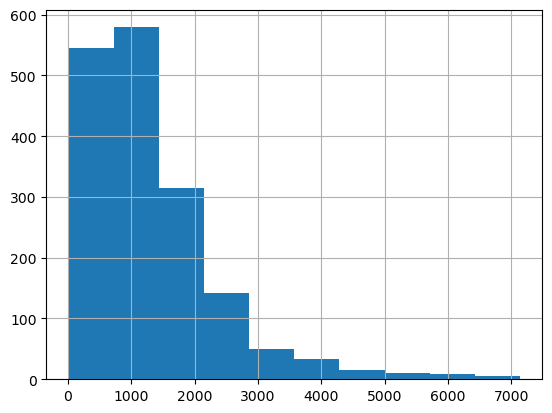

In [15]:
## Statistics
print(lsoa_centroid["nearest_station_distance"].describe())
lsoa_centroid["nearest_station_distance"].hist()

In [16]:
lsoa_centroid

,LSOA21CD,GlobalID,geometry,nearest_station_distance
0,E01004894,383beb3b-8da0-4477-9ade-4be2ebb0ab15,POINT (365726.271 406203.286),584.113340
1,E01004901,23dcd995-ad83-4f95-b6bc-37d68f343348,POINT (366007.383 406571.516),583.787237
2,E01033218,6ed77315-6e5b-47a9-a152-0ea26b2ea717,POINT (366176.952 406884.503),755.671321
3,E01005001,be241a8f-ce27-4dda-88bd-64b2392f5038,POINT (375937.543 408214.672),2682.823140
4,E01004918,e5dc4a4c-f5a2-46f2-a9df-07ea12a7909e,POINT (375471.213 408031.697),2278.393157
...,...,...,...,...
1697,E01006304,965b1305-d1c6-4273-8079-af3fc3b1cc02,POINT (362820.689 397135.462),6620.757668
1698,E01006408,31fa7bce-1c84-4ce0-bc42-ec95996fc622,POINT (356979.157 403522.069),1358.725328
1699,E01006371,a391716f-f834-4263-833e-377d93905bf0,POINT (357558.209 406497.316),1112.522533
1700,E01006400,cac1b74b-e228-484c-980d-c861f0f54529,POINT (355978.007 403450.440),588.128763


In [17]:
## Merge nearest_station_distance to lsoa_supply
lsoa_supply = pd.merge(lsoa_supply, lsoa_centroid[["LSOA21CD", "nearest_station_distance"]], left_on="lsoa21cd", right_on="LSOA21CD")
lsoa_supply = lsoa_supply.drop(columns=["LSOA21CD"])
lsoa_supply

,lsoa21cd,lsoa21nm,geometry,area_sqkm,bus_stops_count,bus_stops_density,nearest_station_distance
0,E01004901,Bolton 028E,"POLYGON ((366003.093 406666.688, 366004.412 40...",0.354363,4,11.287876,583.787237
1,E01005001,Bury 012B,"POLYGON ((375480.348 408593.123, 375481.063 40...",0.238302,4,16.785438,2682.823140
2,E01004840,Bolton 012A,"POLYGON ((367374.781 411954.594, 367387.095 41...",4.181101,25,5.979287,2153.166001
3,E01005006,Bury 012D,"POLYGON ((377212.688 410849.500, 377231.906 41...",1.772635,26,14.667433,2828.181650
4,E01004773,Bolton 003D,"POLYGON ((371776.559 412463.204, 371825.243 41...",0.266227,9,33.805782,1467.288813
...,...,...,...,...,...,...,...
1697,E01006410,Wigan 020E,"POLYGON ((357596.954 403017.375, 357616.740 40...",0.628715,8,12.724362,2090.861678
1698,E01006400,Wigan 021D,"POLYGON ((356213.760 403792.397, 356213.312 40...",0.569408,1,1.756210,588.128763
1699,E01006331,Wigan 031D,"POLYGON ((367336.970 401009.452, 367340.657 40...",0.596520,6,10.058336,3640.594673
1700,E01006397,Wigan 011C,"POLYGON ((354859.312 406046.904, 354861.775 40...",0.147755,4,27.071827,1516.597364


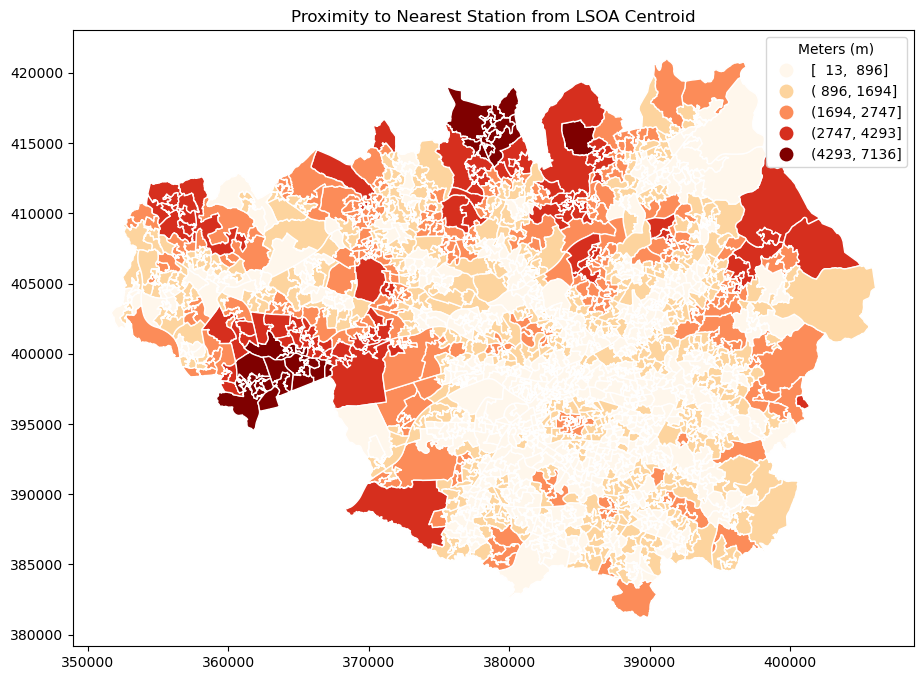

In [18]:
## Plot proximity to nearest station
fig, ax = plt.subplots(1,1, figsize=(12,8))

lsoa_supply.plot(column="nearest_station_distance",
                cmap="OrRd",
                ax=ax,
                edgecolor="1",
                legend=True,
                legend_kwds=dict(fmt="{:.0f}", interval=True),
                scheme="natural_breaks")

ax.set_title("Proximity to Nearest Station from LSOA Centroid")
#ax.axis("off")
ax.get_legend().set_title("Meters (m)")
#ax.get_legend().set_bbox_to_anchor((0, 1))

In [68]:
lsoa_supply.nsmallest(10, 'nearest_station_distance')

,lsoa21cd,lsoa21nm,geometry,area_sqkm,bus_stops_count,bus_stops_density,nearest_station_distance
591,E01033983,Salford 021I,"POLYGON ((379749.000 398692.000, 379760.326 39...",0.835204,33,39.511315,13.167773
855,E01033997,Salford 037C,"POLYGON ((381267.589 397583.407, 381275.086 39...",0.283584,27,95.209971,26.788935
907,E01034131,Manchester 060E,"POLYGON ((383426.354 397692.053, 383431.000 39...",0.095903,11,114.699681,56.106500
468,E01005176,Manchester 043E,"POLYGON ((384664.755 391565.945, 384665.062 39...",0.274708,12,43.682685,57.699951
791,E01005125,Manchester 040A,"POLYGON ((385971.462 391986.302, 385971.847 39...",0.229112,7,30.552720,60.255510
510,E01033662,Manchester 057C,"POLYGON ((384073.225 397814.088, 384076.000 39...",0.144958,18,124.174290,60.398737
660,E01033654,Manchester 055C,"POLYGON ((384762.116 398315.767, 384769.817 39...",0.277819,26,93.586138,67.443837
266,E01006290,Wigan 022A,"POLYGON ((368728.469 404022.416, 368736.405 40...",0.504252,12,23.797621,74.523319
1127,E01005477,Rochdale 017B,"POLYGON ((388516.000 411343.000, 388573.000 41...",0.446944,27,60.410242,75.307379
1490,E01005900,Stockport 010C,"POLYGON ((394105.838 391125.936, 394109.339 39...",0.602970,17,28.193754,86.611861


## Populations

In [20]:
## Filter only population within Greater Manchester

pop_lsoa = df_pop[df_pop["LSOA 2021 Code"].isin(gdf_lsoa["lsoa21cd"].unique())]
pop_lsoa["Total"] = pop_lsoa["Total"].str.replace(",", "").astype(int)

/tmp/ipykernel_9764/1361827563.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_lsoa["Total"] = pop_lsoa["Total"].str.replace(",", "").astype(int)


In [21]:
pop_lsoa

,LAD 2021 Code,LAD 2021 Name,LSOA 2021 Code,LSOA 2021 Name,Total,F0,F1,F2,F3,F4,...,M81,M82,M83,M84,M85,M86,M87,M88,M89,M90
530,E06000007,Warrington,E01012472,Warrington 001B,1865,0,14,5,5,10,...,5,11,6,11,4,6,0,0,7,4
533,E06000007,Warrington,E01012475,Warrington 002C,1495,6,5,10,5,5,...,5,5,6,6,0,6,6,0,0,5
534,E06000007,Warrington,E01012476,Warrington 001C,1578,7,5,10,5,5,...,5,5,6,0,6,0,6,7,0,5
535,E06000007,Warrington,E01012477,Warrington 001D,1614,3,5,5,10,5,...,5,5,6,6,6,6,0,0,0,10
573,E06000007,Warrington,E01012517,Warrington 021E,2340,12,14,10,10,15,...,5,5,5,5,0,0,7,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23612,E08000013,St. Helens,E01006885,St. Helens 001D,1327,0,5,5,5,5,...,5,4,0,5,5,0,0,7,0,5
27554,E08000033,Calderdale,E01010886,Calderdale 022C,1121,5,10,5,0,5,...,5,0,6,6,0,6,0,0,0,0
27623,E08000033,Calderdale,E01010955,Calderdale 027D,1400,8,5,5,10,5,...,0,5,0,0,0,0,0,0,0,0
27743,E08000034,Kirklees,E01011075,Kirklees 052C,1452,3,0,5,5,10,...,5,0,0,5,5,6,6,6,0,5


### Population Density

In [22]:
## Drop unnecessary columns
lsoa_demand = gdf_lsoa.drop(columns = ["label", "name"])

## Calculate area of each LSOA in square meters
lsoa_demand["area_sqkm"] = lsoa_demand["geometry"].area / 10**6

In [23]:
lsoa_demand = pd.merge(lsoa_demand, pop_lsoa[["LSOA 2021 Code", "Total"]], left_on = "lsoa21cd", right_on = "LSOA 2021 Code")
lsoa_demand = lsoa_demand.drop(columns=["LSOA 2021 Code"])

In [24]:
## Calculate population density

lsoa_demand["pop_density"] = lsoa_demand["Total"] / lsoa_demand["area_sqkm"]
lsoa_demand

,lsoa21cd,lsoa21nm,geometry,area_sqkm,Total,pop_density
0,E01004901,Bolton 028E,"POLYGON ((366003.093 406666.688, 366004.412 40...",0.354363,1773,5003.350923
1,E01005001,Bury 012B,"POLYGON ((375480.348 408593.123, 375481.063 40...",0.238302,1228,5153.129520
2,E01004840,Bolton 012A,"POLYGON ((367374.781 411954.594, 367387.095 41...",4.181101,1769,423.094327
3,E01005006,Bury 012D,"POLYGON ((377212.688 410849.500, 377231.906 41...",1.772635,2051,1157.034831
4,E01004773,Bolton 003D,"POLYGON ((371776.559 412463.204, 371825.243 41...",0.266227,1985,7456.052936
...,...,...,...,...,...,...
1764,E01006410,Wigan 020E,"POLYGON ((357596.954 403017.375, 357616.740 40...",0.628715,1261,2005.677534
1765,E01006400,Wigan 021D,"POLYGON ((356213.760 403792.397, 356213.312 40...",0.569408,1982,3480.807917
1766,E01006331,Wigan 031D,"POLYGON ((367336.970 401009.452, 367340.657 40...",0.596520,1501,2516.260480
1767,E01006397,Wigan 011C,"POLYGON ((354859.312 406046.904, 354861.775 40...",0.147755,1058,7160.498266


<Axes: >

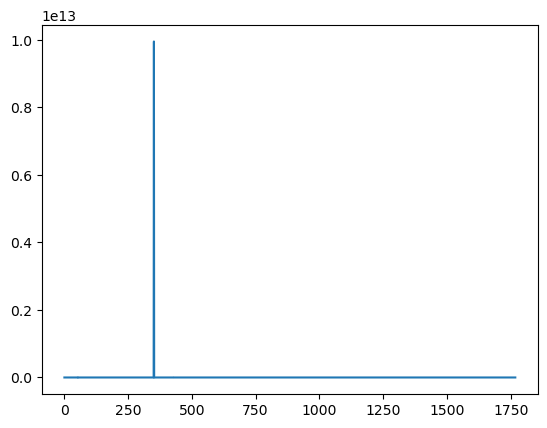

In [25]:
## Check for any outliers
lsoa_demand.pop_density.plot()

In [26]:
## Finding out the significant outliers
outlier = lsoa_demand[lsoa_demand.pop_density > 100000] 
print(outlier)

## Drop outlier out of pop_lsoa, so that the rest of the variables are not affected
lsoa_demand = lsoa_demand.drop(outlier.index)

       lsoa21cd                    lsoa21nm  \
36    E01024973                Chorley 014E   
46    E01032485  Blackburn with Darwen 018E   
50    E01024916                Chorley 014B   
53    E01024915                Chorley 014A   
111   E01024961                Chorley 013D   
...         ...                         ...   
1685  E01006836             St. Helens 005A   
1732  E01006805             St. Helens 003B   
1733  E01012477             Warrington 001D   
1734  E01025539        West Lancashire 005E   
1741  E01025537        West Lancashire 015D   

                                               geometry     area_sqkm  Total  \
36    MULTIPOLYGON (((363220.625 411835.282, 363211....  4.502977e-05   2103   
46    MULTIPOLYGON (((372971.452 414385.322, 372965....  4.275347e-05   1916   
50    MULTIPOLYGON (((358521.703 411152.424, 358517....  1.424313e-03   1729   
53    MULTIPOLYGON (((360575.800 412708.400, 360601....  4.180183e-07   2721   
111   MULTIPOLYGON (((356383.000 41

In [27]:
lsoa_demand

,lsoa21cd,lsoa21nm,geometry,area_sqkm,Total,pop_density
0,E01004901,Bolton 028E,"POLYGON ((366003.093 406666.688, 366004.412 40...",0.354363,1773,5003.350923
1,E01005001,Bury 012B,"POLYGON ((375480.348 408593.123, 375481.063 40...",0.238302,1228,5153.129520
2,E01004840,Bolton 012A,"POLYGON ((367374.781 411954.594, 367387.095 41...",4.181101,1769,423.094327
3,E01005006,Bury 012D,"POLYGON ((377212.688 410849.500, 377231.906 41...",1.772635,2051,1157.034831
4,E01004773,Bolton 003D,"POLYGON ((371776.559 412463.204, 371825.243 41...",0.266227,1985,7456.052936
...,...,...,...,...,...,...
1764,E01006410,Wigan 020E,"POLYGON ((357596.954 403017.375, 357616.740 40...",0.628715,1261,2005.677534
1765,E01006400,Wigan 021D,"POLYGON ((356213.760 403792.397, 356213.312 40...",0.569408,1982,3480.807917
1766,E01006331,Wigan 031D,"POLYGON ((367336.970 401009.452, 367340.657 40...",0.596520,1501,2516.260480
1767,E01006397,Wigan 011C,"POLYGON ((354859.312 406046.904, 354861.775 40...",0.147755,1058,7160.498266


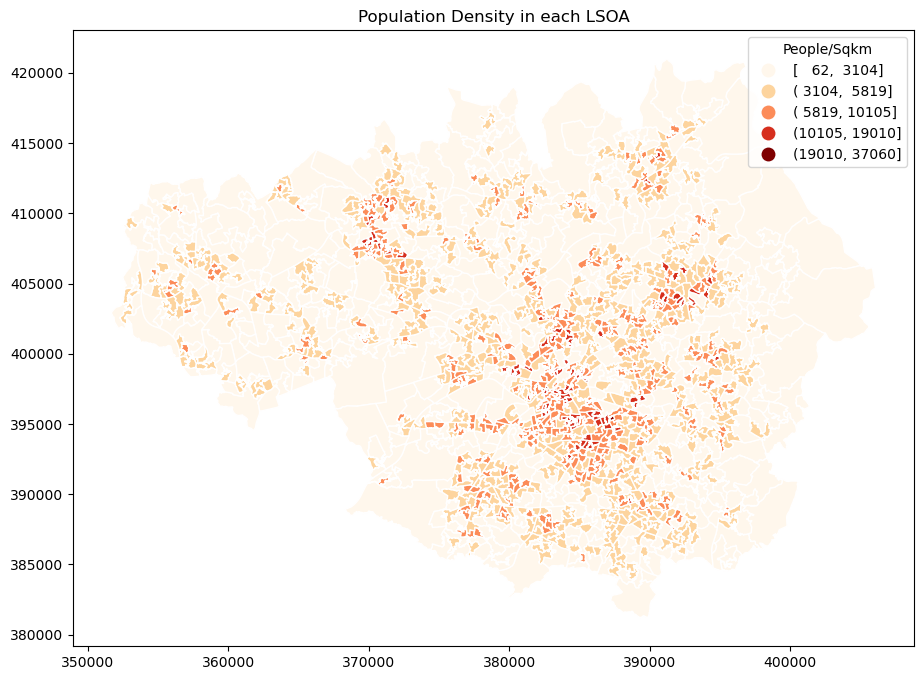

In [28]:
## Plot percentage of women
fig, ax = plt.subplots(1,1, figsize=(12,8))

lsoa_demand.plot(column="pop_density",
                cmap="OrRd",
                ax=ax,
                edgecolor="1",
                legend=True,
                legend_kwds=dict(fmt='{:.0f}', interval=True),
                scheme="natural_breaks")

ax.set_title("Population Density in each LSOA")
#ax.axis("off")
ax.get_legend().set_title("People/Sqkm")
#ax.get_legend().set_bbox_to_anchor((0, 1))

plt.show()

In [29]:
lsoa_demand.nlargest(20, "pop_density")

,lsoa21cd,lsoa21nm,geometry,area_sqkm,Total,pop_density
538,E01033684,Manchester 062D,"POLYGON ((385659.317 398106.322, 385686.000 39...",0.048328,1791,37059.608501
510,E01005233,Manchester 063B,"POLYGON ((387458.393 395575.643, 387460.779 39...",0.103451,2898,28013.206537
471,E01033994,Salford 036B,"POLYGON ((382588.604 397521.079, 382579.001 39...",0.041129,1134,27571.876659
981,E01034125,Manchester 025G,"POLYGON ((384585.997 395319.512, 384586.570 39...",0.061067,1553,25430.948631
623,E01034138,Manchester 064B,"POLYGON ((387609.305 394859.598, 387607.616 39...",0.058235,1363,23405.017785
876,E01033673,Manchester 059D,"POLYGON ((382812.854 397513.965, 382833.000 39...",0.064342,1411,21929.579992
525,E01005614,Salford 031C,"POLYGON ((383266.903 401400.181, 383261.307 40...",0.164076,3119,19009.510033
501,E01034122,Manchester 024E,"POLYGON ((384069.904 395401.701, 384079.263 39...",0.097914,1832,18710.364998
897,E01034134,Manchester 061D,"POLYGON ((385304.919 398882.031, 385318.000 39...",0.062760,1157,18435.224003
784,E01005199,Manchester 064C,"POLYGON ((387724.713 394809.500, 387724.320 39...",0.136517,2492,18254.105427


### Young Adult Women Population (18-29 years old)

In [30]:
## Checking the columns for female aged 18-29
print(pop_lsoa.columns[23:35])

## Checking data types and any outlier
print(pop_lsoa[list(pop_lsoa.columns[23:35])].dtypes)
print(pop_lsoa["F19"].unique())

Index(['F18', 'F19', 'F20', 'F21', 'F22', 'F23', 'F24', 'F25', 'F26', 'F27',
       'F28', 'F29'],
      dtype='object')
F18     int64
F19    object
F20     int64
F21     int64
F22     int64
F23     int64
F24     int64
F25     int64
F26     int64
F27     int64
F28     int64
F29     int64
dtype: object
['5' '0' '11' '10' '9' '4' '6' '16' '21' '31' '26' '36' '14' '19' '15'
 '133' '29' '24' '49' '468' '162' '414' '424' '123' '98' '473' '192' '79'
 '39' '93' '384' '74' '59' '296' '167' '197' '500' '104' '41']


In [31]:
## Convert F19 column to numeric
pop_lsoa["F19"] = pop_lsoa["F19"].apply(pd.to_numeric, errors='coerce')

/tmp/ipykernel_9764/3735554503.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_lsoa["F19"] = pop_lsoa["F19"].apply(pd.to_numeric, errors='coerce')


In [32]:
## Create a list of columns for young adult women
women_column = list(pop_lsoa.columns[23:35])

## Create a new column 'women' that sums all these columns
pop_lsoa["women_pop"] = pop_lsoa[women_column].sum(axis=1)

## Create a new column 'women_percentage' that calculates the percentage of 'women' over 'Total'
pop_lsoa["women_percentage"] = pop_lsoa["women_pop"] / pop_lsoa["Total"] * 100
pop_lsoa

/tmp/ipykernel_9764/613156241.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_lsoa["women_pop"] = pop_lsoa[women_column].sum(axis=1)
/tmp/ipykernel_9764/613156241.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_lsoa["women_percentage"] = pop_lsoa["women_pop"] / pop_lsoa["Total"] * 100


,LAD 2021 Code,LAD 2021 Name,LSOA 2021 Code,LSOA 2021 Name,Total,F0,F1,F2,F3,F4,...,M83,M84,M85,M86,M87,M88,M89,M90,women_pop,women_percentage
530,E06000007,Warrington,E01012472,Warrington 001B,1865,0,14,5,5,10,...,6,11,4,6,0,0,7,4,81,4.343164
533,E06000007,Warrington,E01012475,Warrington 002C,1495,6,5,10,5,5,...,6,6,0,6,6,0,0,5,60,4.013378
534,E06000007,Warrington,E01012476,Warrington 001C,1578,7,5,10,5,5,...,6,0,6,0,6,7,0,5,80,5.069708
535,E06000007,Warrington,E01012477,Warrington 001D,1614,3,5,5,10,5,...,6,6,6,6,0,0,0,10,50,3.097893
573,E06000007,Warrington,E01012517,Warrington 021E,2340,12,14,10,10,15,...,5,5,0,0,7,0,0,4,108,4.615385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23612,E08000013,St. Helens,E01006885,St. Helens 001D,1327,0,5,5,5,5,...,0,5,5,0,0,7,0,5,45,3.391108
27554,E08000033,Calderdale,E01010886,Calderdale 022C,1121,5,10,5,0,5,...,6,6,0,6,0,0,0,0,65,5.798394
27623,E08000033,Calderdale,E01010955,Calderdale 027D,1400,8,5,5,10,5,...,0,0,0,0,0,0,0,0,65,4.642857
27743,E08000034,Kirklees,E01011075,Kirklees 052C,1452,3,0,5,5,10,...,0,5,5,6,6,6,0,5,80,5.509642


### Elderly Population (> 64 years old)

In [33]:
## Checking the columns for female 65+ and male 65+
print(pop_lsoa.columns[70:96])
print(pop_lsoa.columns[161:])

Index(['F65', 'F66', 'F67', 'F68', 'F69', 'F70', 'F71', 'F72', 'F73', 'F74',
       'F75', 'F76', 'F77', 'F78', 'F79', 'F80', 'F81', 'F82', 'F83', 'F84',
       'F85', 'F86', 'F87', 'F88', 'F89', 'F90'],
      dtype='object')
Index(['M65', 'M66', 'M67', 'M68', 'M69', 'M70', 'M71', 'M72', 'M73', 'M74',
       'M75', 'M76', 'M77', 'M78', 'M79', 'M80', 'M81', 'M82', 'M83', 'M84',
       'M85', 'M86', 'M87', 'M88', 'M89', 'M90', 'women_pop',
       'women_percentage'],
      dtype='object')


In [34]:
# Create new columns for elderly counts and percentage

## Create a list of columns for elderly male and female
elderly_f = pop_lsoa.columns[70:96]
elderly_m = pop_lsoa.columns[161:]

elderly_column = list(elderly_f) + list(elderly_m)

## Create a new column 'Population 65+' that sums all these columns
pop_lsoa["elderly_pop"] = pop_lsoa[elderly_column].sum(axis=1)

## Create a new column 'Elderly Percentage' that calculates the percentage of 'Population 65+' over 'Total'
pop_lsoa["elderly_percentage"] = pop_lsoa["elderly_pop"] / pop_lsoa["Total"] * 100
pop_lsoa

/tmp/ipykernel_9764/1869302055.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_lsoa["elderly_pop"] = pop_lsoa[elderly_column].sum(axis=1)
/tmp/ipykernel_9764/1869302055.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_lsoa["elderly_percentage"] = pop_lsoa["elderly_pop"] / pop_lsoa["Total"] * 100


,LAD 2021 Code,LAD 2021 Name,LSOA 2021 Code,LSOA 2021 Name,Total,F0,F1,F2,F3,F4,...,M85,M86,M87,M88,M89,M90,women_pop,women_percentage,elderly_pop,elderly_percentage
530,E06000007,Warrington,E01012472,Warrington 001B,1865,0,14,5,5,10,...,4,6,0,0,7,4,81,4.343164,555.343164,29.777113
533,E06000007,Warrington,E01012475,Warrington 002C,1495,6,5,10,5,5,...,0,6,6,0,0,5,60,4.013378,392.013378,26.221631
534,E06000007,Warrington,E01012476,Warrington 001C,1578,7,5,10,5,5,...,6,0,6,7,0,5,80,5.069708,476.069708,30.169183
535,E06000007,Warrington,E01012477,Warrington 001D,1614,3,5,5,10,5,...,6,6,0,0,0,10,50,3.097893,365.097893,22.620687
573,E06000007,Warrington,E01012517,Warrington 021E,2340,12,14,10,10,15,...,0,0,7,0,0,4,108,4.615385,496.615385,21.222880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23612,E08000013,St. Helens,E01006885,St. Helens 001D,1327,0,5,5,5,5,...,5,0,0,7,0,5,45,3.391108,442.391108,33.337687
27554,E08000033,Calderdale,E01010886,Calderdale 022C,1121,5,10,5,0,5,...,0,6,0,0,0,0,65,5.798394,334.798394,29.866048
27623,E08000033,Calderdale,E01010955,Calderdale 027D,1400,8,5,5,10,5,...,0,0,0,0,0,0,65,4.642857,345.642857,24.688776
27743,E08000034,Kirklees,E01011075,Kirklees 052C,1452,3,0,5,5,10,...,5,6,6,6,0,5,80,5.509642,443.509642,30.544741


### Children Population (< 17 years old)

In [35]:
## Checking the columns for female 17- and male 17-
print(pop_lsoa.columns[5:22])
print(pop_lsoa.columns[96:113])

Index(['F0', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10',
       'F11', 'F12', 'F13', 'F14', 'F15', 'F16'],
      dtype='object')
Index(['M0', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10',
       'M11', 'M12', 'M13', 'M14', 'M15', 'M16'],
      dtype='object')


In [36]:
# Create new columns for children counts and percentage

## Create a list of columns for children male and female

children_f = pop_lsoa.columns[5:22]
children_m = pop_lsoa.columns[96:113]

children_column = list(children_f) + list(children_m)

## Create a new column 'Population 65+' that sums all these columns
pop_lsoa["children_pop"] = pop_lsoa[children_column].sum(axis=1)

## Create a new column 'Elderly Percentage' that calculates the percentage of 'Population 65+' over 'Total'
pop_lsoa["children_percentage"] = pop_lsoa["children_pop"] / pop_lsoa["Total"] * 100
pop_lsoa

/tmp/ipykernel_9764/469105569.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_lsoa["children_pop"] = pop_lsoa[children_column].sum(axis=1)
/tmp/ipykernel_9764/469105569.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_lsoa["children_percentage"] = pop_lsoa["children_pop"] / pop_lsoa["Total"] * 100


,LAD 2021 Code,LAD 2021 Name,LSOA 2021 Code,LSOA 2021 Name,Total,F0,F1,F2,F3,F4,...,M87,M88,M89,M90,women_pop,women_percentage,elderly_pop,elderly_percentage,children_pop,children_percentage
530,E06000007,Warrington,E01012472,Warrington 001B,1865,0,14,5,5,10,...,0,0,7,4,81,4.343164,555.343164,29.777113,354,18.981233
533,E06000007,Warrington,E01012475,Warrington 002C,1495,6,5,10,5,5,...,6,0,0,5,60,4.013378,392.013378,26.221631,274,18.327759
534,E06000007,Warrington,E01012476,Warrington 001C,1578,7,5,10,5,5,...,6,7,0,5,80,5.069708,476.069708,30.169183,257,16.286439
535,E06000007,Warrington,E01012477,Warrington 001D,1614,3,5,5,10,5,...,0,0,0,10,50,3.097893,365.097893,22.620687,307,19.021066
573,E06000007,Warrington,E01012517,Warrington 021E,2340,12,14,10,10,15,...,7,0,0,4,108,4.615385,496.615385,21.222880,557,23.803419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23612,E08000013,St. Helens,E01006885,St. Helens 001D,1327,0,5,5,5,5,...,0,7,0,5,45,3.391108,442.391108,33.337687,192,14.468726
27554,E08000033,Calderdale,E01010886,Calderdale 022C,1121,5,10,5,0,5,...,0,0,0,0,65,5.798394,334.798394,29.866048,215,19.179304
27623,E08000033,Calderdale,E01010955,Calderdale 027D,1400,8,5,5,10,5,...,0,0,0,0,65,4.642857,345.642857,24.688776,265,18.928571
27743,E08000034,Kirklees,E01011075,Kirklees 052C,1452,3,0,5,5,10,...,6,6,0,5,80,5.509642,443.509642,30.544741,251,17.286501


In [37]:
## Merge total population, 65+ percentage, 16- percentage to the gdf

lsoa_demand = pd.merge(lsoa_demand, pop_lsoa[["LSOA 2021 Code", "women_percentage", "elderly_percentage", "children_percentage"]], left_on = "lsoa21cd", right_on = "LSOA 2021 Code")

In [38]:
lsoa_demand

,lsoa21cd,lsoa21nm,geometry,area_sqkm,Total,pop_density,LSOA 2021 Code,women_percentage,elderly_percentage,children_percentage
0,E01004901,Bolton 028E,"POLYGON ((366003.093 406666.688, 366004.412 40...",0.354363,1773,5003.350923,E01004901,5.922166,29.606439,15.172025
1,E01005001,Bury 012B,"POLYGON ((375480.348 408593.123, 375481.063 40...",0.238302,1228,5153.129520,E01005001,4.885993,22.384853,19.218241
2,E01004840,Bolton 012A,"POLYGON ((367374.781 411954.594, 367387.095 41...",4.181101,1769,423.094327,E01004840,4.578858,30.275798,19.106840
3,E01005006,Bury 012D,"POLYGON ((377212.688 410849.500, 377231.906 41...",1.772635,2051,1157.034831,E01005006,6.874695,25.688674,20.234032
4,E01004773,Bolton 003D,"POLYGON ((371776.559 412463.204, 371825.243 41...",0.266227,1985,7456.052936,E01004773,7.103275,25.395631,19.143577
...,...,...,...,...,...,...,...,...,...,...
1697,E01006410,Wigan 020E,"POLYGON ((357596.954 403017.375, 357616.740 40...",0.628715,1261,2005.677534,E01006410,4.758128,33.287718,15.543220
1698,E01006400,Wigan 021D,"POLYGON ((356213.760 403792.397, 356213.312 40...",0.569408,1982,3480.807917,E01006400,6.004036,18.415945,26.135217
1699,E01006331,Wigan 031D,"POLYGON ((367336.970 401009.452, 367340.657 40...",0.596520,1501,2516.260480,E01006331,3.997335,28.514146,16.122585
1700,E01006397,Wigan 011C,"POLYGON ((354859.312 406046.904, 354861.775 40...",0.147755,1058,7160.498266,E01006397,7.088847,32.333539,16.446125


In [39]:
## Drop redundant column

lsoa_demand = lsoa_demand.drop(columns=["LSOA 2021 Code"])

In [40]:
lsoa_demand

,lsoa21cd,lsoa21nm,geometry,area_sqkm,Total,pop_density,women_percentage,elderly_percentage,children_percentage
0,E01004901,Bolton 028E,"POLYGON ((366003.093 406666.688, 366004.412 40...",0.354363,1773,5003.350923,5.922166,29.606439,15.172025
1,E01005001,Bury 012B,"POLYGON ((375480.348 408593.123, 375481.063 40...",0.238302,1228,5153.129520,4.885993,22.384853,19.218241
2,E01004840,Bolton 012A,"POLYGON ((367374.781 411954.594, 367387.095 41...",4.181101,1769,423.094327,4.578858,30.275798,19.106840
3,E01005006,Bury 012D,"POLYGON ((377212.688 410849.500, 377231.906 41...",1.772635,2051,1157.034831,6.874695,25.688674,20.234032
4,E01004773,Bolton 003D,"POLYGON ((371776.559 412463.204, 371825.243 41...",0.266227,1985,7456.052936,7.103275,25.395631,19.143577
...,...,...,...,...,...,...,...,...,...
1697,E01006410,Wigan 020E,"POLYGON ((357596.954 403017.375, 357616.740 40...",0.628715,1261,2005.677534,4.758128,33.287718,15.543220
1698,E01006400,Wigan 021D,"POLYGON ((356213.760 403792.397, 356213.312 40...",0.569408,1982,3480.807917,6.004036,18.415945,26.135217
1699,E01006331,Wigan 031D,"POLYGON ((367336.970 401009.452, 367340.657 40...",0.596520,1501,2516.260480,3.997335,28.514146,16.122585
1700,E01006397,Wigan 011C,"POLYGON ((354859.312 406046.904, 354861.775 40...",0.147755,1058,7160.498266,7.088847,32.333539,16.446125


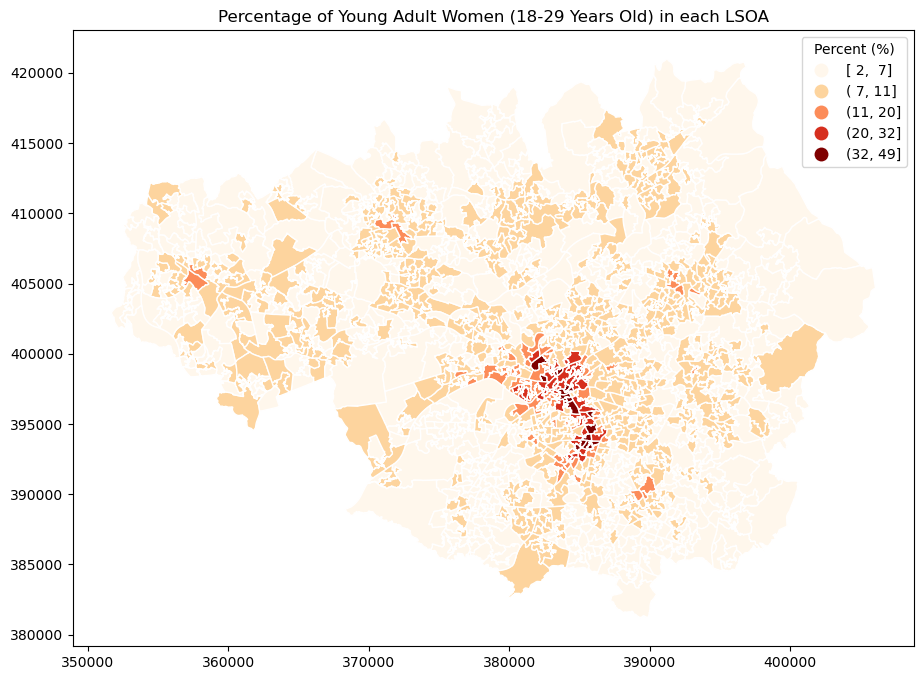

In [41]:
## Plot percentage of women
fig, ax = plt.subplots(1,1, figsize=(12,8))

lsoa_demand.plot(column="women_percentage",
                cmap="OrRd",
                ax=ax,
                edgecolor="1",
                legend=True,
                legend_kwds=dict(fmt='{:.0f}', interval=True),
                scheme="natural_breaks")

ax.set_title("Percentage of Young Adult Women (18-29 Years Old) in each LSOA")
ax.get_legend().set_title("Percent (%)")
#ax.get_legend().set_bbox_to_anchor((0, 1))
#ax.axis("off")

In [42]:
lsoa_demand.nlargest(15, "women_percentage")

,lsoa21cd,lsoa21nm,geometry,area_sqkm,Total,pop_density,women_percentage,elderly_percentage,children_percentage
700,E01005185,Manchester 032B,"POLYGON ((385784.168 394303.316, 385798.813 39...",0.233703,3160,13521.416957,48.607595,50.304038,1.265823
610,E01033656,Manchester 057B,"POLYGON ((383883.999 397493.000, 383898.000 39...",0.209650,2646,12621.014569,47.619048,49.418709,0.037793
776,E01005128,Manchester 055A,"POLYGON ((384536.551 397680.952, 384500.000 39...",0.136542,1947,14259.306765,44.067797,46.331166,0.000000
723,E01005281,Manchester 026B,"POLYGON ((386220.184 394924.368, 386227.904 39...",0.455234,2550,5601.513688,42.745098,48.735102,1.882353
579,E01005210,Manchester 019C,"POLYGON ((384153.632 396891.980, 384161.000 39...",0.217393,2590,11913.892075,41.544402,44.885884,9.227799
891,E01034117,Manchester 019E,"POLYGON ((384602.594 396586.094, 384616.514 39...",0.523848,2188,4176.788071,38.848263,40.623778,7.084095
549,E01005610,Salford 034C,"POLYGON ((382382.589 399864.740, 382401.425 39...",0.670964,2936,4375.792062,38.283379,42.857063,11.035422
506,E01005271,Manchester 032C,"POLYGON ((385327.813 393868.406, 385351.041 39...",0.182898,1893,10350.031903,38.246170,43.172011,4.965663
510,E01033662,Manchester 057C,"POLYGON ((384073.225 397814.088, 384076.000 39...",0.144958,1950,13452.214717,37.487179,40.178830,0.871795
839,E01005312,Manchester 036E,"POLYGON ((385690.267 393693.850, 385708.766 39...",0.122174,1921,15723.518287,37.376366,45.360560,2.030193


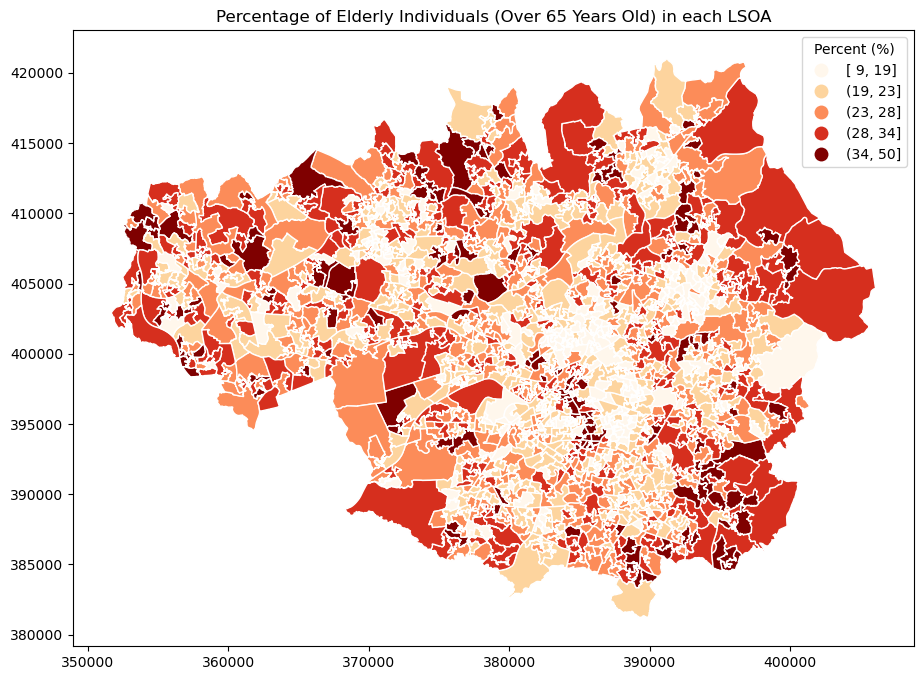

In [43]:
## Plot percentage of Elderly
fig, ax = plt.subplots(1,1, figsize=(12,8))

lsoa_demand.plot(column="elderly_percentage",
                cmap="OrRd",
                ax=ax,
                edgecolor="1",
                legend=True,
                legend_kwds=dict(fmt='{:.0f}', interval=True),
                scheme="natural_breaks")

ax.set_title("Percentage of Elderly Individuals (Over 65 Years Old) in each LSOA")
ax.get_legend().set_title("Percent (%)")
#ax.get_legend().set_bbox_to_anchor((0, 1))
#ax.axis("off")

In [44]:
lsoa_demand.nlargest(10, "elderly_percentage")

,lsoa21cd,lsoa21nm,geometry,area_sqkm,Total,pop_density,women_percentage,elderly_percentage,children_percentage
700,E01005185,Manchester 032B,"POLYGON ((385784.168 394303.316, 385798.813 39...",0.233703,3160,13521.416957,48.607595,50.304038,1.265823
610,E01033656,Manchester 057B,"POLYGON ((383883.999 397493.000, 383898.000 39...",0.209650,2646,12621.014569,47.619048,49.418709,0.037793
170,E01004952,Bury 010D,"POLYGON ((377733.163 410398.712, 377739.360 41...",0.347771,1313,3775.477162,3.046458,48.975359,11.728865
723,E01005281,Manchester 026B,"POLYGON ((386220.184 394924.368, 386227.904 39...",0.455234,2550,5601.513688,42.745098,48.735102,1.882353
776,E01005128,Manchester 055A,"POLYGON ((384536.551 397680.952, 384500.000 39...",0.136542,1947,14259.306765,44.067797,46.331166,0.000000
1399,E01005906,Stockport 038B,"POLYGON ((396624.600 385610.200, 396603.604 38...",0.953019,1453,1524.628531,3.785272,45.546130,11.080523
839,E01005312,Manchester 036E,"POLYGON ((385690.267 393693.850, 385708.766 39...",0.122174,1921,15723.518287,37.376366,45.360560,2.030193
579,E01005210,Manchester 019C,"POLYGON ((384153.632 396891.980, 384161.000 39...",0.217393,2590,11913.892075,41.544402,44.885884,9.227799
1449,E01005907,Stockport 038C,"POLYGON ((396183.142 386248.559, 396194.947 38...",0.880783,1311,1488.447507,4.576659,43.827358,13.196034
506,E01005271,Manchester 032C,"POLYGON ((385327.813 393868.406, 385351.041 39...",0.182898,1893,10350.031903,38.246170,43.172011,4.965663


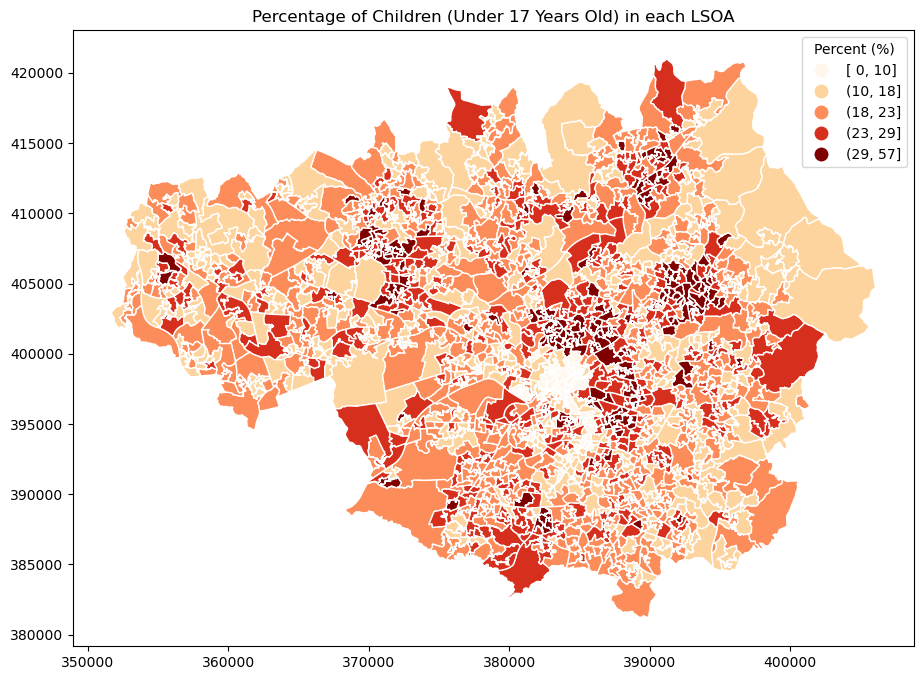

In [45]:
## Plot percentage of children
fig, ax = plt.subplots(1,1, figsize=(12,8))

lsoa_demand.plot(column="children_percentage",
                cmap="OrRd",
                ax=ax,
                edgecolor="1",
                legend=True,
                legend_kwds=dict(fmt='{:.0f}', interval=True),
                scheme="natural_breaks")

ax.set_title("Percentage of Children (Under 17 Years Old) in each LSOA")
ax.get_legend().set_title("Percent (%)")
#ax.get_legend().set_bbox_to_anchor((0, 1))
#ax.axis("off")

In [46]:
lsoa_demand.nlargest(10, "children_percentage")

,lsoa21cd,lsoa21nm,geometry,area_sqkm,Total,pop_density,women_percentage,elderly_percentage,children_percentage
509,E01005614,Salford 031C,"POLYGON ((383266.903 401400.181, 383261.307 40...",0.164076,3119,19009.510033,7.053543,10.036984,56.524527
319,E01005044,Bury 026E,"POLYGON ((382076.495 402611.347, 382077.225 40...",0.144048,2016,13995.327690,6.547619,14.263275,44.692460
433,E01005650,Salford 010C,"POLYGON ((382921.654 401816.594, 382922.002 40...",0.436762,2007,4595.178217,6.576981,16.321723,41.654210
290,E01005043,Bury 026D,"POLYGON ((382531.785 403141.437, 382561.000 40...",0.222179,1961,8826.220173,6.221316,16.890429,41.560428
414,E01005651,Salford 010D,"POLYGON ((383761.094 401851.704, 383761.273 40...",0.226680,2312,10199.398161,6.358131,14.202341,38.494810
1088,E01005428,Oldham 019A,"POLYGON ((394063.758 405292.099, 394066.465 40...",0.277887,2365,8510.643378,9.048626,14.166961,38.181818
828,E01005246,Manchester 024D,"POLYGON ((383804.816 395529.225, 383806.366 39...",0.141384,2534,17922.834778,8.958169,13.928894,37.687451
1184,E01005579,Rochdale 004B,"POLYGON ((391261.000 414566.000, 391265.000 41...",0.363131,1870,5149.655665,6.684492,12.389545,36.684492
1051,E01005348,Oldham 014A,"POLYGON ((392190.848 406290.859, 392196.000 40...",0.194283,2421,12461.177069,6.402313,15.919137,36.513837
811,E01005615,Salford 032D,"POLYGON ((382737.790 401280.492, 382742.157 40...",0.225337,2396,10632.965902,8.347245,18.253224,36.227045


## Disabled People - Car Ownership

In [47]:
df_car_disabled

,Lower layer Super Output Areas Code,Lower layer Super Output Areas,Number of disabled people in household (3 categories) Code,Number of disabled people in household (3 categories),Car or van availability (4 categories) Code,Car or van availability (4 categories),Observation
0,E01000001,City of London 001A,-8,Does not apply,-8,Does not apply,0
1,E01000001,City of London 001A,-8,Does not apply,0,No cars or vans in household,0
2,E01000001,City of London 001A,-8,Does not apply,1,1 car or van in household,0
3,E01000001,City of London 001A,-8,Does not apply,2,2 or more cars or vans in household,0
4,E01000001,City of London 001A,0,No people disabled under the Equality Act in h...,-8,Does not apply,0
...,...,...,...,...,...,...,...
428011,W01002040,Vale of Glamorgan 015F,0,No people disabled under the Equality Act in h...,2,2 or more cars or vans in household,264
428012,W01002040,Vale of Glamorgan 015F,1,1 or more people disabled under the Equality A...,-8,Does not apply,0
428013,W01002040,Vale of Glamorgan 015F,1,1 or more people disabled under the Equality A...,0,No cars or vans in household,55
428014,W01002040,Vale of Glamorgan 015F,1,1 or more people disabled under the Equality A...,1,1 car or van in household,120


In [48]:
## Filter only rows which fulfil the condition of 1 or more disabled people in the household AND having no car
car_disabled = df_car_disabled[(df_car_disabled["Number of disabled people in household (3 categories) Code"] == 1) & (df_car_disabled["Car or van availability (4 categories) Code"] == 0)]

## Filter only in Greater Manchester
car_disabled = car_disabled[car_disabled["Lower layer Super Output Areas Code"].isin(lsoa_demand["lsoa21cd"].unique())]

In [49]:
car_disabled

,Lower layer Super Output Areas Code,Lower layer Super Output Areas,Number of disabled people in household (3 categories) Code,Number of disabled people in household (3 categories),Car or van availability (4 categories) Code,Car or van availability (4 categories),Observation
54081,E01004766,Bolton 005A,1,1 or more people disabled under the Equality A...,0,No cars or vans in household,148
54093,E01004767,Bolton 005B,1,1 or more people disabled under the Equality A...,0,No cars or vans in household,98
54105,E01004768,Bolton 001A,1,1 or more people disabled under the Equality A...,0,No cars or vans in household,15
54117,E01004769,Bolton 003A,1,1 or more people disabled under the Equality A...,0,No cars or vans in household,33
54129,E01004770,Bolton 003B,1,1 or more people disabled under the Equality A...,0,No cars or vans in household,29
...,...,...,...,...,...,...,...
386145,E01034138,Manchester 064B,1,1 or more people disabled under the Equality A...,0,No cars or vans in household,82
387237,E01034232,Oldham 036A,1,1 or more people disabled under the Equality A...,0,No cars or vans in household,70
387249,E01034233,Oldham 036B,1,1 or more people disabled under the Equality A...,0,No cars or vans in household,67
387261,E01034234,Rochdale 008H,1,1 or more people disabled under the Equality A...,0,No cars or vans in household,57


In [50]:
df_household

,Lower layer Super Output Areas Code,Lower layer Super Output Areas,Observation
0,E01000001,City of London 001A,838
1,E01000002,City of London 001B,824
2,E01000003,City of London 001C,1017
3,E01000005,City of London 001E,480
4,E01000006,Barking and Dagenham 016A,554
...,...,...,...
35667,W01002036,Vale of Glamorgan 005G,773
35668,W01002037,Vale of Glamorgan 005H,565
35669,W01002038,Vale of Glamorgan 014G,580
35670,W01002039,Vale of Glamorgan 014H,668


In [51]:
## Merge number of households to the disabled-no car df

df_household = df_household.rename(columns={"Observation": "num_households"})
car_disabled = pd.merge(car_disabled, df_household[["Lower layer Super Output Areas Code", "num_households"]], on="Lower layer Super Output Areas Code")

## Calculate disabled-no car percentage

car_disabled["dis_nc_percentage"] = car_disabled["Observation"] / car_disabled["num_households"] * 100

In [52]:
car_disabled

,Lower layer Super Output Areas Code,Lower layer Super Output Areas,Number of disabled people in household (3 categories) Code,Number of disabled people in household (3 categories),Car or van availability (4 categories) Code,Car or van availability (4 categories),Observation,num_households,dis_nc_percentage
0,E01004766,Bolton 005A,1,1 or more people disabled under the Equality A...,0,No cars or vans in household,148,805,18.385093
1,E01004767,Bolton 005B,1,1 or more people disabled under the Equality A...,0,No cars or vans in household,98,854,11.475410
2,E01004768,Bolton 001A,1,1 or more people disabled under the Equality A...,0,No cars or vans in household,15,613,2.446982
3,E01004769,Bolton 003A,1,1 or more people disabled under the Equality A...,0,No cars or vans in household,33,683,4.831625
4,E01004770,Bolton 003B,1,1 or more people disabled under the Equality A...,0,No cars or vans in household,29,611,4.746318
...,...,...,...,...,...,...,...,...,...
1697,E01034138,Manchester 064B,1,1 or more people disabled under the Equality A...,0,No cars or vans in household,82,453,18.101545
1698,E01034232,Oldham 036A,1,1 or more people disabled under the Equality A...,0,No cars or vans in household,70,433,16.166282
1699,E01034233,Oldham 036B,1,1 or more people disabled under the Equality A...,0,No cars or vans in household,67,431,15.545244
1700,E01034234,Rochdale 008H,1,1 or more people disabled under the Equality A...,0,No cars or vans in household,57,457,12.472648


In [53]:
## Merge disabled-no car observation to the gdf
lsoa_demand = pd.merge(lsoa_demand, car_disabled[["Lower layer Super Output Areas Code", "dis_nc_percentage"]], left_on="lsoa21cd", right_on="Lower layer Super Output Areas Code")

## Drop redundant column
lsoa_demand = lsoa_demand.drop(columns=["Lower layer Super Output Areas Code"])

lsoa_demand

,lsoa21cd,lsoa21nm,geometry,area_sqkm,Total,pop_density,women_percentage,elderly_percentage,children_percentage,dis_nc_percentage
0,E01004901,Bolton 028E,"POLYGON ((366003.093 406666.688, 366004.412 40...",0.354363,1773,5003.350923,5.922166,29.606439,15.172025,5.045278
1,E01005001,Bury 012B,"POLYGON ((375480.348 408593.123, 375481.063 40...",0.238302,1228,5153.129520,4.885993,22.384853,19.218241,2.828283
2,E01004840,Bolton 012A,"POLYGON ((367374.781 411954.594, 367387.095 41...",4.181101,1769,423.094327,4.578858,30.275798,19.106840,7.756233
3,E01005006,Bury 012D,"POLYGON ((377212.688 410849.500, 377231.906 41...",1.772635,2051,1157.034831,6.874695,25.688674,20.234032,7.434944
4,E01004773,Bolton 003D,"POLYGON ((371776.559 412463.204, 371825.243 41...",0.266227,1985,7456.052936,7.103275,25.395631,19.143577,8.974359
...,...,...,...,...,...,...,...,...,...,...
1697,E01006410,Wigan 020E,"POLYGON ((357596.954 403017.375, 357616.740 40...",0.628715,1261,2005.677534,4.758128,33.287718,15.543220,5.617978
1698,E01006400,Wigan 021D,"POLYGON ((356213.760 403792.397, 356213.312 40...",0.569408,1982,3480.807917,6.004036,18.415945,26.135217,2.057613
1699,E01006331,Wigan 031D,"POLYGON ((367336.970 401009.452, 367340.657 40...",0.596520,1501,2516.260480,3.997335,28.514146,16.122585,3.125000
1700,E01006397,Wigan 011C,"POLYGON ((354859.312 406046.904, 354861.775 40...",0.147755,1058,7160.498266,7.088847,32.333539,16.446125,17.636684


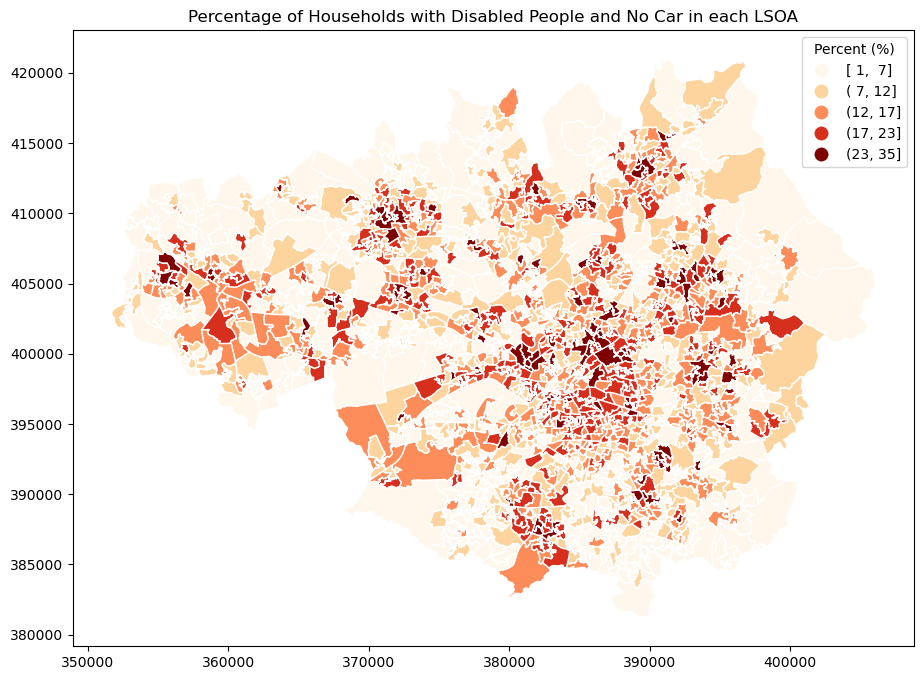

In [54]:
## Plot percentage of households with disabled people and no car
fig, ax = plt.subplots(1,1, figsize=(12,8))

lsoa_demand.plot(column="dis_nc_percentage",
                cmap="OrRd",
                ax=ax,
                edgecolor="1",
                legend=True,
                legend_kwds=dict(fmt='{:.0f}', interval=True),
                scheme="natural_breaks")

ax.set_title("Percentage of Households with Disabled People and No Car in each LSOA")
ax.get_legend().set_title("Percent (%)")
#ax.get_legend().set_bbox_to_anchor((0, 1))
#ax.axis("off")

In [55]:
lsoa_demand.nlargest(10, "dis_nc_percentage")

,lsoa21cd,lsoa21nm,geometry,area_sqkm,Total,pop_density,women_percentage,elderly_percentage,children_percentage,dis_nc_percentage
75,E01006386,Wigan 009C,"POLYGON ((358866.505 406020.287, 358866.863 40...",0.235319,1582,6722.781164,4.740834,26.405868,15.613148,35.193133
715,E01005918,Stockport 014D,"POLYGON ((390022.732 391318.291, 390000.000 39...",0.330370,1615,4888.461416,6.501548,23.498548,23.467492,35.054022
1019,E01005350,Oldham 014B,"POLYGON ((392130.907 405966.432, 392131.000 40...",0.497946,2436,4892.099062,8.251232,20.248409,26.477833,34.619003
437,E01005754,Stockport 004B,"POLYGON ((390607.548 393101.450, 390611.942 39...",0.448028,2019,4506.415136,8.122833,18.579635,23.675087,34.459459
592,E01005682,Salford 024D,"POLYGON ((381098.056 399157.689, 381131.630 39...",0.167611,1736,10357.342064,9.043779,24.311278,18.145161,32.964824
1307,E01005631,Salford 020A,"POLYGON ((378030.813 399258.268, 378041.342 39...",0.278721,1601,5744.085872,6.933167,33.225057,9.868832,32.918660
1500,E01033949,Tameside 013F,"POLYGON ((393444.877 399091.062, 393433.243 39...",0.138252,1166,8433.876088,11.492281,18.910144,21.269297,31.525424
1166,E01005482,Rochdale 010C,"POLYGON ((389829.381 413936.390, 389831.999 41...",0.857657,1677,1955.327769,6.618962,19.357124,20.214669,31.354983
625,E01033679,Manchester 009G,"POLYGON ((385700.730 400741.408, 385700.858 40...",0.338853,1382,4078.465901,7.959479,17.869716,24.167873,30.636833
871,E01005189,Manchester 017D,"POLYGON ((388677.175 396860.052, 388672.399 39...",0.374716,1714,4574.125183,6.126021,21.594284,25.379230,30.625000


## Deprived Households

In [56]:
df_deprived

,Lower layer Super Output Areas Code,Lower layer Super Output Areas,Household deprived in the employment dimension (3 categories) Code,Household deprived in the employment dimension (3 categories),Observation
0,E01000001,City of London 001A,-8,Does not apply,0
1,E01000001,City of London 001A,0,Household is not deprived in the employment di...,802
2,E01000001,City of London 001A,1,Household is deprived in the employment dimension,39
3,E01000002,City of London 001B,-8,Does not apply,0
4,E01000002,City of London 001B,0,Household is not deprived in the employment di...,794
...,...,...,...,...,...
107011,W01002039,Vale of Glamorgan 014H,0,Household is not deprived in the employment di...,610
107012,W01002039,Vale of Glamorgan 014H,1,Household is deprived in the employment dimension,58
107013,W01002040,Vale of Glamorgan 015F,-8,Does not apply,0
107014,W01002040,Vale of Glamorgan 015F,0,Household is not deprived in the employment di...,820


In [57]:
## Filter only rows which fulfil the condition of household is deprived in the employment dimension
deprived_lsoa = df_deprived[(df_deprived["Household deprived in the employment dimension (3 categories) Code"] == 1)]

## Filter only in Greater Manchester
deprived_lsoa = deprived_lsoa[deprived_lsoa["Lower layer Super Output Areas Code"].isin(lsoa_demand["lsoa21cd"].unique())]

deprived_lsoa

,Lower layer Super Output Areas Code,Lower layer Super Output Areas,Household deprived in the employment dimension (3 categories) Code,Household deprived in the employment dimension (3 categories),Observation
13520,E01004766,Bolton 005A,1,Household is deprived in the employment dimension,115
13523,E01004767,Bolton 005B,1,Household is deprived in the employment dimension,103
13526,E01004768,Bolton 001A,1,Household is deprived in the employment dimension,30
13529,E01004769,Bolton 003A,1,Household is deprived in the employment dimension,52
13532,E01004770,Bolton 003B,1,Household is deprived in the employment dimension,45
...,...,...,...,...,...
96539,E01034138,Manchester 064B,1,Household is deprived in the employment dimension,99
96812,E01034232,Oldham 036A,1,Household is deprived in the employment dimension,120
96815,E01034233,Oldham 036B,1,Household is deprived in the employment dimension,136
96818,E01034234,Rochdale 008H,1,Household is deprived in the employment dimension,110


In [58]:
## Merge number of households to deprived_lsoa
deprived_lsoa = pd.merge(deprived_lsoa, df_household[["Lower layer Super Output Areas Code", "num_households"]], on="Lower layer Super Output Areas Code")

## Calculate deprived households percentage
deprived_lsoa["deprived_percentage"] = deprived_lsoa["Observation"] / deprived_lsoa["num_households"] * 100

deprived_lsoa

,Lower layer Super Output Areas Code,Lower layer Super Output Areas,Household deprived in the employment dimension (3 categories) Code,Household deprived in the employment dimension (3 categories),Observation,num_households,deprived_percentage
0,E01004766,Bolton 005A,1,Household is deprived in the employment dimension,115,805,14.285714
1,E01004767,Bolton 005B,1,Household is deprived in the employment dimension,103,854,12.060890
2,E01004768,Bolton 001A,1,Household is deprived in the employment dimension,30,613,4.893964
3,E01004769,Bolton 003A,1,Household is deprived in the employment dimension,52,683,7.613470
4,E01004770,Bolton 003B,1,Household is deprived in the employment dimension,45,611,7.364975
...,...,...,...,...,...,...,...
1697,E01034138,Manchester 064B,1,Household is deprived in the employment dimension,99,453,21.854305
1698,E01034232,Oldham 036A,1,Household is deprived in the employment dimension,120,433,27.713626
1699,E01034233,Oldham 036B,1,Household is deprived in the employment dimension,136,431,31.554524
1700,E01034234,Rochdale 008H,1,Household is deprived in the employment dimension,110,457,24.070022


In [59]:
## Merge deprived household percentage to the gdf
lsoa_demand = pd.merge(lsoa_demand, deprived_lsoa[["Lower layer Super Output Areas Code", "deprived_percentage"]], left_on="lsoa21cd", right_on="Lower layer Super Output Areas Code")

## Drop redundant column
lsoa_demand = lsoa_demand.drop(columns=["Lower layer Super Output Areas Code"])

In [60]:
lsoa_demand

,lsoa21cd,lsoa21nm,geometry,area_sqkm,Total,pop_density,women_percentage,elderly_percentage,children_percentage,dis_nc_percentage,deprived_percentage
0,E01004901,Bolton 028E,"POLYGON ((366003.093 406666.688, 366004.412 40...",0.354363,1773,5003.350923,5.922166,29.606439,15.172025,5.045278,6.856404
1,E01005001,Bury 012B,"POLYGON ((375480.348 408593.123, 375481.063 40...",0.238302,1228,5153.129520,4.885993,22.384853,19.218241,2.828283,7.676768
2,E01004840,Bolton 012A,"POLYGON ((367374.781 411954.594, 367387.095 41...",4.181101,1769,423.094327,4.578858,30.275798,19.106840,7.756233,9.418283
3,E01005006,Bury 012D,"POLYGON ((377212.688 410849.500, 377231.906 41...",1.772635,2051,1157.034831,6.874695,25.688674,20.234032,7.434944,10.532838
4,E01004773,Bolton 003D,"POLYGON ((371776.559 412463.204, 371825.243 41...",0.266227,1985,7456.052936,7.103275,25.395631,19.143577,8.974359,8.158508
...,...,...,...,...,...,...,...,...,...,...,...
1697,E01006410,Wigan 020E,"POLYGON ((357596.954 403017.375, 357616.740 40...",0.628715,1261,2005.677534,4.758128,33.287718,15.543220,5.617978,7.490637
1698,E01006400,Wigan 021D,"POLYGON ((356213.760 403792.397, 356213.312 40...",0.569408,1982,3480.807917,6.004036,18.415945,26.135217,2.057613,7.270233
1699,E01006331,Wigan 031D,"POLYGON ((367336.970 401009.452, 367340.657 40...",0.596520,1501,2516.260480,3.997335,28.514146,16.122585,3.125000,5.625000
1700,E01006397,Wigan 011C,"POLYGON ((354859.312 406046.904, 354861.775 40...",0.147755,1058,7160.498266,7.088847,32.333539,16.446125,17.636684,19.047619


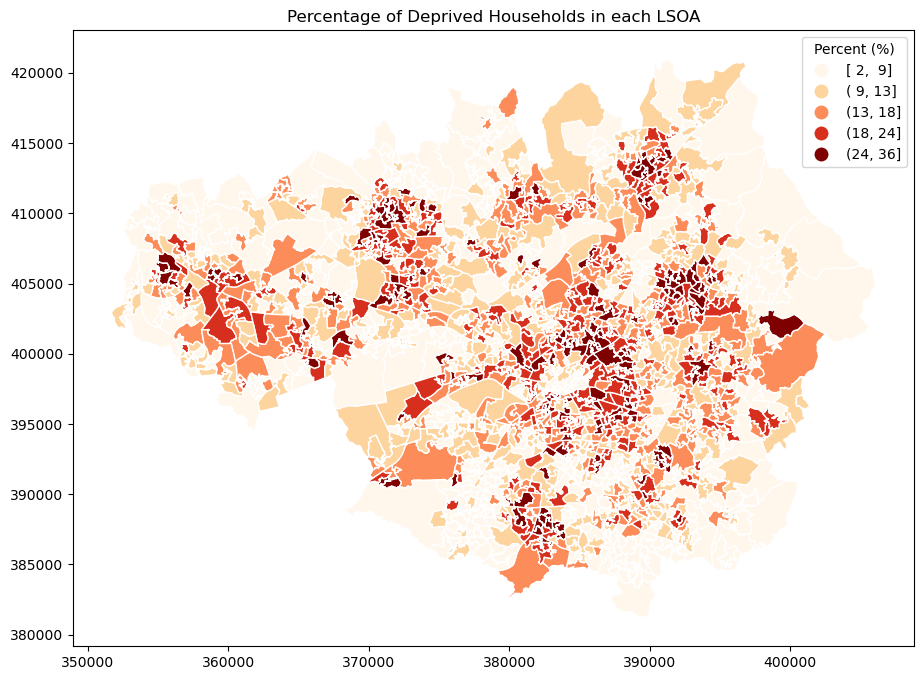

In [61]:
## Plot percentage of deprived households
fig, ax = plt.subplots(1,1, figsize=(12,8))

lsoa_demand.plot(column="deprived_percentage",
                cmap="OrRd",
                ax=ax,
                edgecolor="1",
                legend=True,
                legend_kwds=dict(fmt='{:.0f}', interval=True),
                scheme="natural_breaks")

ax.set_title("Percentage of Deprived Households in each LSOA")
ax.get_legend().set_title("Percent (%)")
#ax.get_legend().set_bbox_to_anchor((0, 1))
#ax.axis("off")

In [62]:
lsoa_demand.nlargest(10, "deprived_percentage")

,lsoa21cd,lsoa21nm,geometry,area_sqkm,Total,pop_density,women_percentage,elderly_percentage,children_percentage,dis_nc_percentage,deprived_percentage
1500,E01033949,Tameside 013F,"POLYGON ((393444.877 399091.062, 393433.243 39...",0.138252,1166,8433.876088,11.492281,18.910144,21.269297,31.525424,36.271186
715,E01005918,Stockport 014D,"POLYGON ((390022.732 391318.291, 390000.000 39...",0.330370,1615,4888.461416,6.501548,23.498548,23.467492,35.054022,36.134454
437,E01005754,Stockport 004B,"POLYGON ((390607.548 393101.450, 390611.942 39...",0.448028,2019,4506.415136,8.122833,18.579635,23.675087,34.459459,34.652510
1039,E01005326,Oldham 022B,"POLYGON ((393491.858 404383.370, 393493.416 40...",0.223176,2994,13415.405839,11.823647,24.242607,26.920508,12.589928,34.172662
1421,E01005828,Stockport 024D,"POLYGON ((392201.330 388603.055, 392206.528 38...",0.217045,1380,6358.137409,5.797101,18.825877,29.275362,25.220459,33.686067
1166,E01005482,Rochdale 010C,"POLYGON ((389829.381 413936.390, 389831.999 41...",0.857657,1677,1955.327769,6.618962,19.357124,20.214669,31.354983,33.482643
1019,E01005350,Oldham 014B,"POLYGON ((392130.907 405966.432, 392131.000 40...",0.497946,2436,4892.099062,8.251232,20.248409,26.477833,34.619003,33.301976
1107,E01005321,Oldham 022A,"POLYGON ((392900.148 404383.702, 392906.000 40...",0.766788,2317,3021.697008,6.473889,13.227186,33.707380,14.814815,32.528180
1225,E01005353,Oldham 016D,"POLYGON ((391594.000 405534.000, 391594.478 40...",0.382236,1479,3869.335595,11.899932,18.316425,29.141312,18.137255,32.107843
687,E01005613,Salford 031A,"POLYGON ((383568.086 401401.797, 383564.654 40...",0.293140,2719,9275.416367,8.127988,16.554909,30.599485,19.180819,31.968032


## Export to csv

In [63]:
lsoa_supply.to_csv("Data/Output/lsoa_supply.csv")
lsoa_demand.to_csv("Data/Output/lsoa_demand.csv")

## Export to shp

In [64]:
lsoa_supply.to_file("Data/Output/lsoa_supply.shp")
lsoa_demand.to_file("Data/Output/lsoa_demand.shp")

/tmp/ipykernel_9764/1674086188.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  lsoa_supply.to_file("Data/Output/lsoa_supply.shp")
/tmp/ipykernel_9764/1674086188.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  lsoa_demand.to_file("Data/Output/lsoa_demand.shp")
